In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf


random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error as mse

In [3]:
import pandas as pd

csv_file_path = 'close.csv'

df = pd.read_csv(csv_file_path, header=None)

close = df[0].tolist()
logclose = np.log(close).tolist()




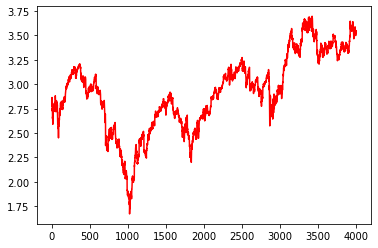

In [4]:
from math import floor

size = len(logclose)-100
close_train, close_test = close[0:size], close[size:len(close)]
logclose_train, logclose_test = logclose[0:size], logclose[size:len(logclose)]

series = logclose
train = logclose_train
test = logclose_test

plt.plot(series , color = 'r')
plt.show()


In [5]:
predicted_list, error_list = [], []
training_data = train

In [6]:
import pandas as pd

csv_file_path = 'forecasted_logclose_ARIMA_t_GARCH_t.csv'

df = pd.read_csv(csv_file_path, header=None)

predicted_list = df[0].tolist()

print(predicted_list)

[3.3426, 3.3364, 3.324, 3.3312, 3.339, 3.3479, 3.3478, 3.3825, 3.3904, 3.3926, 3.4003, 3.4261, 3.4467, 3.4371, 3.4409, 3.4606, 3.4877, 3.4976, 3.4869, 3.4897, 3.5014, 3.4914, 3.6453, 3.6001, 3.5643, 3.5684, 3.5711, 3.5913, 3.596, 3.5897, 3.5926, 3.594, 3.5953, 3.572, 3.5818, 3.605, 3.5906, 3.5955, 3.592, 3.5919, 3.5597, 3.5477, 3.5564, 3.5556, 3.5506, 3.5516, 3.5458, 3.565, 3.5682, 3.5858, 3.5877, 3.6036, 3.6212, 3.6379, 3.6417, 3.6219, 3.6162, 3.6383, 3.6312, 3.6335, 3.5924, 3.5928, 3.589, 3.5703, 3.5873, 3.5611, 3.5197, 3.4901, 3.4886, 3.4675, 3.4975, 3.5136, 3.5202, 3.5497, 3.5486, 3.5698, 3.5822, 3.545, 3.5506, 3.564, 3.5581, 3.5751, 3.5724, 3.5729, 3.5501, 3.5686, 3.5893, 3.5672, 3.566, 3.539, 3.522, 3.5327, 3.5115, 3.5085, 3.501, 3.5063, 3.5203, 3.5394, 3.5428, 3.5507]


In [7]:
for t in range(len(test)):
    predicted_value = predicted_list[t]
    obs = test[t]
    error_list.append(obs - predicted_value)
    training_data.append(obs)
    print('predicted=%f, expected=%f error=%f' % (predicted_value, obs,abs(predicted_value-obs)))

predicted=3.342600, expected=3.335414 error=0.007186
predicted=3.336400, expected=3.323236 error=0.013164
predicted=3.324000, expected=3.330059 error=0.006059
predicted=3.331200, expected=3.338613 error=0.007413
predicted=3.339000, expected=3.347093 error=0.008093
predicted=3.347900, expected=3.346741 error=0.001159
predicted=3.347800, expected=3.382354 error=0.034554
predicted=3.382500, expected=3.389462 error=0.006962
predicted=3.390400, expected=3.391820 error=0.001420
predicted=3.392600, expected=3.399195 error=0.006595
predicted=3.400300, expected=3.426215 error=0.025915
predicted=3.426100, expected=3.445533 error=0.019433
predicted=3.446700, expected=3.436243 error=0.010457
predicted=3.437100, expected=3.440098 error=0.002998
predicted=3.440900, expected=3.460095 error=0.019195
predicted=3.460600, expected=3.487069 error=0.026469
predicted=3.487700, expected=3.496811 error=0.009111
predicted=3.497600, expected=3.485845 error=0.011755
predicted=3.486900, expected=3.488903 error=0.

In [8]:
error = mse(test, predicted_list)
print('Test MSE: %.3f' % error)

Test MSE: 0.001


In [9]:
import pandas as pd

csv_file_path = 'rawResiduals_ARIMA_t_GARCH_t.csv'

df = pd.read_csv(csv_file_path, header=None)

training_error = np.array(df[0].tolist())

print(training_error)


[-0.017041    0.0081058   0.0061349  ... -0.00017775 -0.0050918
  0.0085437 ]


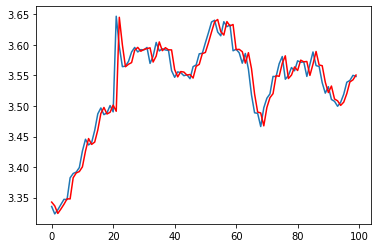

Test MSE: 0.000532


In [10]:
plt.plot(test)
plt.plot(predicted_list, color='red')
plt.show()

error = mse(test,predicted_list)
print('Test MSE: %.6f' % error)

In [11]:
from keras.models import Sequential
from keras.layers import Dense,Activation
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse


training_error = np.array(training_error).reshape(-1,1)

In [12]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

def make_model(num_layers, neurons, activation, initializer, optimizer, dropout_rate, window_size):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    model = Sequential()
    model.add(Dense(neurons[0], input_dim=window_size, kernel_initializer=initializer, activation=activation))
    model.add(Dropout(dropout_rate))
    for i in range(1, num_layers):
        model.add(Dense(neurons[i], kernel_initializer=initializer, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

space = {
    "window_size": hp.choice("window_size", list(range(2, 20))), 
    "num_layers_choice": hp.choice("num_layers_choice", [
         { 
             "num_layers": 1,
             "neurons": hp.quniform("neurons_1", 2, 299, 1)
         }
    ]),
    "activation": hp.choice("activation", ["sigmoid", "tanh", "relu", "elu"]),
    "initializer": hp.choice("initializer", ["uniform", "glorot_uniform", "he_uniform"]),
    "optimizer": hp.choice("optimizer", ["adam", "sgd", "rmsprop"]),
    "dropout_rate": hp.uniform("dropout_rate", 0.0, 0.5),
    "batch_size": hp.quniform("batch_size", 8, 128, 1)
}


def objective(params):
        
    window_size = params["window_size"]

    scaler = RobustScaler()
    training_error_scaled = scaler.fit_transform(training_error)

    arch = params["num_layers_choice"]
    if arch["num_layers"] == 1:
        num_layers = 1
        neurons = [int(arch["neurons"])]
    if arch["num_layers"] == 2:
        num_layers = 2
        neurons = [int(arch["neurons1"]), int(arch["neurons2"])]
    if arch["num_layers"] == 3:
        num_layers = 3
        neurons = [int(arch["neurons1"]), int(arch["neurons2"]), int(arch["neurons3"])]
    
    
    activation = params["activation"]
    initializer = params["initializer"]
    optimizer_param = params["optimizer"]
    dropout_rate = params["dropout_rate"]
    batch_size = int(params["batch_size"])
    
    train_X, train_Y = [], []
    for i in range(len(training_error_scaled) - window_size):
        train_X.append(training_error_scaled[i:i+window_size])
        train_Y.append(training_error_scaled[i+window_size])
    new_train_X = np.array([x.reshape(-1) for x in train_X])
    new_train_Y = np.array(train_Y).ravel()
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    epochs = 2000
    validation_split = 0.10
    
    modelKeras = KerasRegressor(
        model=make_model,
        window_size=window_size,
        model__num_layers=num_layers,
        model__neurons=neurons,
        model__activation=activation,
        model__initializer=initializer,
        model__optimizer=optimizer_param,
        model__dropout_rate=dropout_rate,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=validation_split,
        callbacks=callbacks,
        shuffle=False,
        random_state=42,    
        verbose=0
    )
    
    tscv = TimeSeriesSplit(n_splits=2)
    score = np.mean(cross_val_score(modelKeras, new_train_X, new_train_Y, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1))

    
    print(f"Params: {params}, Score: {score:.4f}")

    return {"loss": -score, "status": STATUS_OK}


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials,
            rstate=np.random.default_rng(42))

best_loss = trials.best_trial['result']['loss']
best_score = best_loss

print("\n------------------------")
print("BEST OVERALL RESULTS:")
print("------------------------")
print("Raw best parameters (indices/values):")
print(best)
print(f"Best score: {best_score:.4f}")

Params: {'activation': 'elu', 'batch_size': 100.0, 'dropout_rate': 0.32587119987444696, 'initializer': 'glorot_uniform', 'num_layers_choice': {'neurons': 186.0, 'num_layers': 1}, 'optimizer': 'rmsprop', 'window_size': 2}, Score: -1.1484
Params: {'activation': 'elu', 'batch_size': 76.0, 'dropout_rate': 0.029968094540700263, 'initializer': 'he_uniform', 'num_layers_choice': {'neurons': 183.0, 'num_layers': 1}, 'optimizer': 'adam', 'window_size': 17}, Score: -1.2317
Params: {'activation': 'relu', 'batch_size': 77.0, 'dropout_rate': 0.07858985028094856, 'initializer': 'uniform', 'num_layers_choice': {'neurons': 24.0, 'num_layers': 1}, 'optimizer': 'adam', 'window_size': 4}, Score: -1.1502
Params: {'activation': 'relu', 'batch_size': 17.0, 'dropout_rate': 0.35223000813752336, 'initializer': 'glorot_uniform', 'num_layers_choice': {'neurons': 65.0, 'num_layers': 1}, 'optimizer': 'sgd', 'window_size': 13}, Score: -1.1802
Params: {'activation': 'tanh', 'batch_size': 49.0, 'dropout_rate': 0.1730

In [13]:
window_sizes = list(range(2, 20))
activations_list = ["sigmoid", "tanh", "relu", "elu"]
initializers_list = ["uniform", "glorot_uniform", "he_uniform"]
optimizers_list = ["adam", "sgd", "rmsprop"]

best_window_size = window_sizes[ best["window_size"] ]
best_activation = activations_list[ best["activation"] ]
best_initializer = initializers_list[ best["initializer"] ]
best_optimizer = optimizers_list[ best["optimizer"] ]
best_dropout_rate = best["dropout_rate"]
best_batch_size = int(best["batch_size"])


if best["num_layers_choice"] == 0:
    best_num_layers = 1
    best_neurons = [int(best["neurons_1"])]
if best["num_layers_choice"] == 1:
    best_num_layers = 2
    best_neurons = [int(best["neurons_2_1"]), int(best["neurons_2_2"])]
if best["num_layers_choice"] == 2:
    best_num_layers = 3
    best_neurons = [int(best["neurons_3_1"]), int(best["neurons_3_2"]), int(best["neurons_3_3"])]


scaler = RobustScaler()
training_error_scaled = scaler.fit_transform(training_error)

train_X, train_Y = [], []
for i in range(0, len(training_error_scaled) - best_window_size):
    train_X.append(training_error_scaled[i:i+best_window_size])
    train_Y.append(training_error_scaled[i+best_window_size])
new_train_X = np.array([x.reshape(-1) for x in train_X])
new_train_Y = np.array(train_Y).ravel()


final_model = make_model(
    num_layers=best_num_layers,
    neurons=best_neurons,
    activation=best_activation,
    initializer=best_initializer,
    optimizer=best_optimizer,
    dropout_rate=best_dropout_rate,
    window_size=best_window_size
)

final_model.fit(new_train_X, new_train_Y,
                batch_size=best_batch_size,
                epochs=2000,
                validation_split=0.10,
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                shuffle=False,
                verbose=1)

Epoch 1/2000
50/50 [==============================] - 1s 5ms/step - loss: 1.2920 - val_loss: 0.7304
Epoch 2/2000
50/50 [==============================] - 0s 3ms/step - loss: 1.2915 - val_loss: 0.7259
Epoch 3/2000
50/50 [==============================] - 0s 3ms/step - loss: 1.2922 - val_loss: 0.7261
Epoch 4/2000
50/50 [==============================] - 0s 2ms/step - loss: 1.2893 - val_loss: 0.7261
Epoch 5/2000
50/50 [==============================] - 0s 2ms/step - loss: 1.2894 - val_loss: 0.7261
Epoch 6/2000
50/50 [==============================] - 0s 2ms/step - loss: 1.2883 - val_loss: 0.7254
Epoch 7/2000
50/50 [==============================] - 0s 2ms/step - loss: 1.2888 - val_loss: 0.7256
Epoch 8/2000
50/50 [==============================] - 0s 3ms/step - loss: 1.2878 - val_loss: 0.7254
Epoch 9/2000
50/50 [==============================] - 0s 2ms/step - loss: 1.2890 - val_loss: 0.7253
Epoch 10/2000
50/50 [==============================] - 0s 2ms/step - loss: 1.2903 - val_loss: 0.7256

In [14]:
print(best_window_size)
print(best_activation)
print(best_initializer)
print(best_optimizer)
print(best_dropout_rate)
print(best_batch_size) 
print(best_neurons) 

4
elu
uniform
adam
0.05674987427076067
71
[226]


In [15]:
window_size = best_window_size
model = final_model

122/122 [==============================] - 0s 825us/step


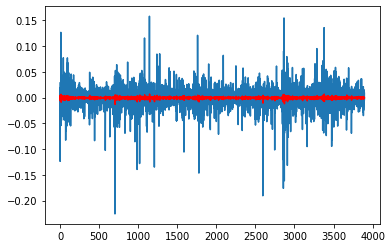

Train MSE: 0.000474


In [16]:
predictions = model.predict(new_train_X)
predictions_rescaled=scaler.inverse_transform(predictions.reshape(-1, 1))
Y = pd.DataFrame(training_error[window_size:])
pred = pd.DataFrame(predictions_rescaled)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
error = mse(training_error[window_size:],predictions_rescaled)
print('Train MSE: %.6f' % error)

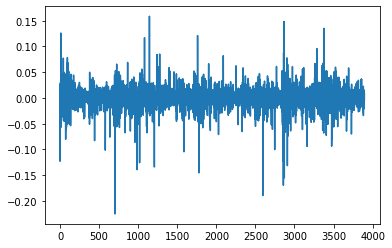

In [17]:
rawResiduals_ARIMA_t_GARCH_t_FNN = Y - pred
plt.plot(rawResiduals_ARIMA_t_GARCH_t_FNN)
plt.show()

rawResiduals_ARIMA_t_GARCH_t_FNN.to_csv('rawResiduals_ARIMA_t_GARCH_t_FNN_BO-TPE_robustscaler.csv', index=False)

4/4 [==============================] - 0s 0s/step


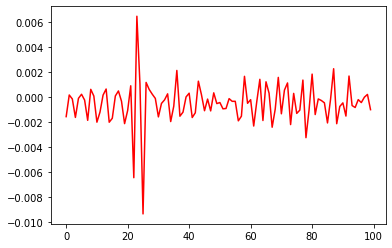

Test MSE: 0.000533


In [18]:
test_extended = training_error.tolist()[-1*window_size:] + error_list
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
        
test_data = np.array(test_data).reshape(-1,1)
test_scaled = scaler.transform(test_data)

test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])

new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_Y = np.array(new_test_Y)


predictions = model.predict(new_test_X)
predictions_rescaled=scaler.inverse_transform(predictions.reshape(-1, 1))


Y = pd.DataFrame(error_list)
pred = pd.DataFrame(predictions_rescaled)

plt.plot(predictions_rescaled , color = 'r')
plt.show()
error = mse(error_list,predictions_rescaled)
print('Test MSE: %.6f' % error)

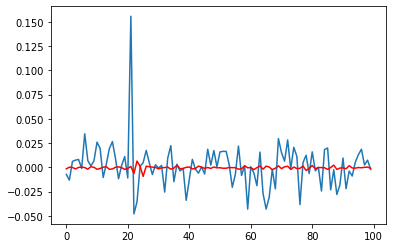

Test MSE: 0.000533


In [19]:
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
error = mse(error_list,predictions_rescaled)
print('Test MSE: %.6f' % error)

Hybrid Test MSE: 0.000533


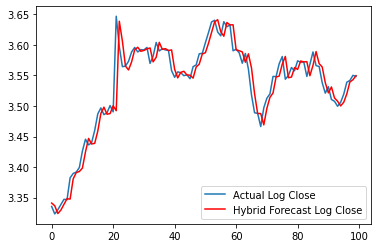

In [20]:
predicted_array = np.array(predicted_list)
final_pred = predicted_array+predictions_rescaled.flatten()
hybrid_error = mse(np.array(test), final_pred)
print('Hybrid Test MSE: %.6f' % hybrid_error)

plt.plot(pd.DataFrame(test), label="Actual Log Close")
plt.plot(pd.DataFrame(final_pred), color='r', label="Hybrid Forecast Log Close")
plt.legend()
plt.show()

In [21]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from forecast_metrics import compute_error_metrics, compute_directional_metrics
print("Errors on logclose: ")
print(compute_error_metrics(test, final_pred))
print(compute_directional_metrics(test, final_pred))


Errors on logclose: 
{'NMSE': 0.09409016194613977, 'MAE': 0.01457437461992057, 'RMSE': 0.023080900494623545, 'MSE': 0.0005327279676427133, 'MAPE': 0.41108057607312737, 'TheilsU': 0.9982427151528475}
{'DA': 0.5555555555555556, 'DS': 0.5050505050505051, 'CU': 0.5789473684210527, 'CD': 0.40476190476190477}


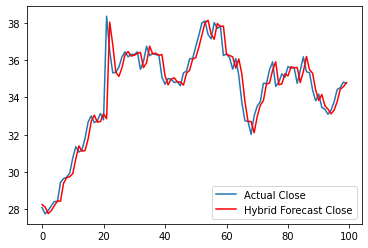

Test MSE: 0.656053


In [22]:
close_pred = np.exp(final_pred)
Y = pd.DataFrame(close_test)
pred = pd.DataFrame(close_pred)
plt.plot(Y, label="Actual Close")
plt.plot(pred , color = 'r', label="Hybrid Forecast Close")
plt.legend()
plt.show()

error = mse(close_test,close_pred)
print('Test MSE: %.6f' % error)

In [23]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from forecast_metrics import compute_error_metrics, compute_directional_metrics
print("Errors on close: ")
print(compute_error_metrics(close_test, close_pred))
print(compute_directional_metrics(close_test, close_pred))

Errors on close: 
{'NMSE': 0.10706839931974775, 'MAE': 0.5037284049929692, 'RMSE': 0.8099710684099207, 'MSE': 0.6560531316611085, 'MAPE': 1.4486357544805777, 'TheilsU': 0.9979370395663175}
{'DA': 0.5555555555555556, 'DS': 0.5050505050505051, 'CU': 0.5789473684210527, 'CD': 0.40476190476190477}


Stock: 28.09 Action: Buy Portfolio: 28090.0 Stocks: 1000 Balance_init: 0 total($) 28090.0
Stock: 27.75 Action: Bought--Holding Portfolio: 27750.0 Stocks: 1000 Balance_init: 0 total($) 27750.0
Stock: 27.94 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 27940.0
Stock: 28.18 Action: Buy Portfolio: 27926.38 Stocks: 991 Balance_init: 13 total($) 27939.38
Stock: 28.42 Action: Bought--Holding Portfolio: 28164.22 Stocks: 991 Balance_init: 13 total($) 28177.22
Stock: 28.41 Action: Bought--Holding Portfolio: 28154.31 Stocks: 991 Balance_init: 13 total($) 28167.31
Stock: 29.44 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29188.04
Stock: 29.65 Action: Buy Portfolio: 29175.6 Stocks: 984 Balance_init: 12 total($) 29187.6
Stock: 29.72 Action: Bought--Holding Portfolio: 29244.48 Stocks: 984 Balance_init: 12 total($) 29256.48
Stock: 29.94 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 total($) 29472.96
Stock: 30.76 Action: Price-Prediction-Already-Lower Portfolio: 0 S

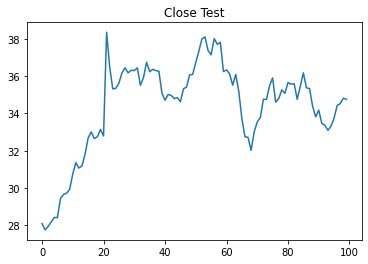

Final value of stock:
34.76


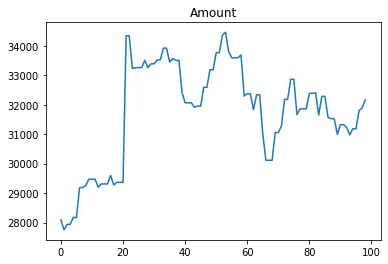

Final value of portfolio:
32162.0


In [ ]:
import sys
sys.path.append('../Functions/Performance Metrics/')
from trading_strategies import trading_strategy1

trading_strategy1(close_test, close_pred)
            